In [1]:
import numpy as np
import pandas as pd 

import glob
import os


from scipy import stats
from scipy import signal

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
BASE_PATH = '../hms-harmful-brain-activity-classification/'

# Create a DataFrame with the paths to all .parquet files under the base path
df = pd.DataFrame({'path': glob.glob(BASE_PATH + '**/*.parquet')})
# Extract test_type from the directory name
df['test_type'] = df['path'].str.split('/').str.get(-2).str.split('_').str.get(-1)
# Extract id from the file name
df['id'] = df['path'].str.split('/').str.get(-1).str.split('.').str.get(0)

# Read a specific Parquet file
df_eeg = pd.read_parquet(BASE_PATH + 'train_eegs/1000913311.parquet')
# Display the first few rows
df_eeg.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-105.849998,-89.230003,-79.459999,-49.230000,-99.730003,-87.769997,-53.330002,-50.740002,-32.250000,-42.099998,-43.270000,-88.730003,-74.410004,-92.459999,-58.930000,-75.739998,-59.470001,8.210000,66.489998,1404.930054
1,-85.470001,-75.070000,-60.259998,-38.919998,-73.080002,-87.510002,-39.680000,-35.630001,-76.839996,-62.740002,-43.040001,-68.629997,-61.689999,-69.320000,-35.790001,-58.900002,-41.660000,196.190002,230.669998,3402.669922
2,8.840000,34.849998,56.430000,67.970001,48.099998,25.350000,80.250000,48.060001,6.720000,37.880001,61.000000,16.580000,55.060001,45.020000,70.529999,47.820000,72.029999,-67.180000,-171.309998,-3565.800049
3,-56.320000,-37.279999,-28.100000,-2.820000,-43.430000,-35.049999,3.910000,-12.660000,8.650000,3.830000,4.180000,-51.900002,-21.889999,-41.330002,-11.580000,-27.040001,-11.730000,-91.000000,-81.190002,-1280.930054
4,-110.139999,-104.519997,-96.879997,-70.250000,-111.660004,-114.430000,-71.830002,-61.919998,-76.150002,-79.779999,-67.480003,-99.029999,-93.610001,-104.410004,-70.070000,-89.250000,-77.260002,155.729996,264.850006,4325.370117


In [3]:
df_eeg.shape

(10000, 20)

In [4]:
n_channels = df_eeg.shape[1]
n_channels

20

In [5]:
df_eeg.columns

Index(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
       'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'],
      dtype='object')

These columns ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'] in an EEG (electroencephalogram) data set represent different electrode placements on the scalp according to the International 10-20 system. This system is a standardized method used in EEGs to describe the location of scalp electrodes. Each code corresponds to a specific area on the scalp where brain activity is measured:

- 'Fp', 'F', 'T', 'C', 'P', 'O' refer to Frontopolar, Frontal, Temporal, Central, Parietal, and Occipital regions respectively.
- Numbers like '1', '2', '3', '4', '5', '6' indicate the side of the hemisphere (odd numbers for the left hemisphere and even numbers for the right).
- 'z' refers to the midline electrodes.

'EKG' likely represents an electrocardiogram measurement, which is sometimes included in EEG recordings for monitoring heart activity.

## Band Feature Extraction
* The function extract_frequency_band_fatures is designed to process a segment of EEG data.
* It divides the EEG signal into different frequency bands: Delta, Theta, Alpha, Beta and Gamma.
EEG signals can be categorized based on their frequency, amplitude, and the state of the subject. Here are some of the common types of EEG signals:

* Delta Waves (0.5-4 Hz): These are the slowest EEG waves, often found in deep sleep, in infants, and in severe brain disorders.

* Theta Waves (4-8 Hz): These waves are typical in light sleep and in relaxation. They are also seen in certain emotional stress conditions and in some brain disorders.

* Alpha Waves (8-13 Hz): Common in relaxed, awake states (especially with closed eyes), these waves are indicative of a relaxed and calm state of mind.

* Beta Waves (13-30 Hz): These are seen during active, focused, or anxious thinking and active concentration. Higher frequency beta waves are associated with stress or anxiety.

* Gamma Waves (>30 Hz): These are involved in higher mental activity, including perception and consciousness.

In [6]:
SPECTROGRAM_PATH = '../hms-harmful-brain-activity-classification/train_spectrograms/'
spectrogram_files = glob.glob(os.path.join(SPECTROGRAM_PATH, '*.parquet'))
print(f"Number of spectrogram parquet files: {len(spectrogram_files)}")

Number of spectrogram parquet files: 11138


In [7]:
# Read each spectrogram into a DataFrame and store in a dictionary (or list)
spectrograms = {}
for file_path in spectrogram_files:
    # Extract the file name (without extension) to use as a key
    file_name = os.path.basename(file_path).split('.')[0]
    spectrograms[file_name] = pd.read_parquet(file_path)

In [8]:
len(spectrograms)

11138

In [9]:
# Example: Access the DataFrame for the first file
first_file_key = list(spectrograms.keys())[0]
first_spectrogram_df = spectrograms[first_file_key]
first_spectrogram_df.head()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,16.15,18.76,23.260000,24.76,15.94,13.13,9.04,4.51,3.68,...,0.09,0.08,0.09,0.10,0.06,0.09,0.06,0.08,0.07,0.07
1,3,13.83,12.76,17.030001,15.18,7.48,7.08,3.99,2.91,3.25,...,0.04,0.05,0.07,0.06,0.06,0.06,0.03,0.06,0.05,0.05
2,5,3.19,4.21,4.020000,4.24,2.54,1.85,1.75,1.51,1.09,...,0.05,0.06,0.07,0.06,0.06,0.05,0.03,0.04,0.03,0.04
3,7,2.06,2.14,2.310000,1.52,1.05,1.30,1.51,1.36,1.49,...,0.08,0.08,0.08,0.06,0.04,0.02,0.04,0.04,0.04,0.04
4,9,2.04,2.12,1.720000,1.40,1.89,2.02,1.22,1.53,1.49,...,0.06,0.04,0.04,0.05,0.04,0.04,0.03,0.03,0.04,0.04


In [10]:
first_spectrogram_df.tail()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
319,639,55.840000,62.549999,64.519997,52.759998,39.419998,32.880001,27.790001,19.490000,12.690000,...,0.08,0.09,0.21,0.22,0.21,0.20,0.14,0.13,0.12,0.11
320,641,10.440000,12.900000,15.040000,14.330000,16.530001,13.050000,12.920000,11.450000,8.200000,...,0.09,0.09,0.08,0.07,0.05,0.08,0.07,0.07,0.07,0.04
321,643,191.970001,227.300003,253.160004,218.669998,166.050003,136.539993,98.449997,86.739998,67.970001,...,0.10,0.12,0.07,0.07,0.08,0.11,0.11,0.10,0.10,0.08
322,645,380.989990,518.580017,519.599976,557.299988,547.239990,368.350006,340.510010,335.079987,192.750000,...,0.22,0.13,0.13,0.10,0.11,0.11,0.12,0.12,0.11,0.07
323,647,219.639999,332.709991,218.380005,333.119995,281.970001,221.000000,276.170013,166.660004,110.910004,...,0.80,0.44,0.52,0.71,0.28,0.31,0.45,0.23,0.38,0.49


In [11]:
first_spectrogram_df.columns

Index(['time', 'LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37',
       'LL_1.56', 'LL_1.76', 'LL_1.95', 'LL_2.15',
       ...
       'RP_18.16', 'RP_18.36', 'RP_18.55', 'RP_18.75', 'RP_18.95', 'RP_19.14',
       'RP_19.34', 'RP_19.53', 'RP_19.73', 'RP_19.92'],
      dtype='object', length=401)

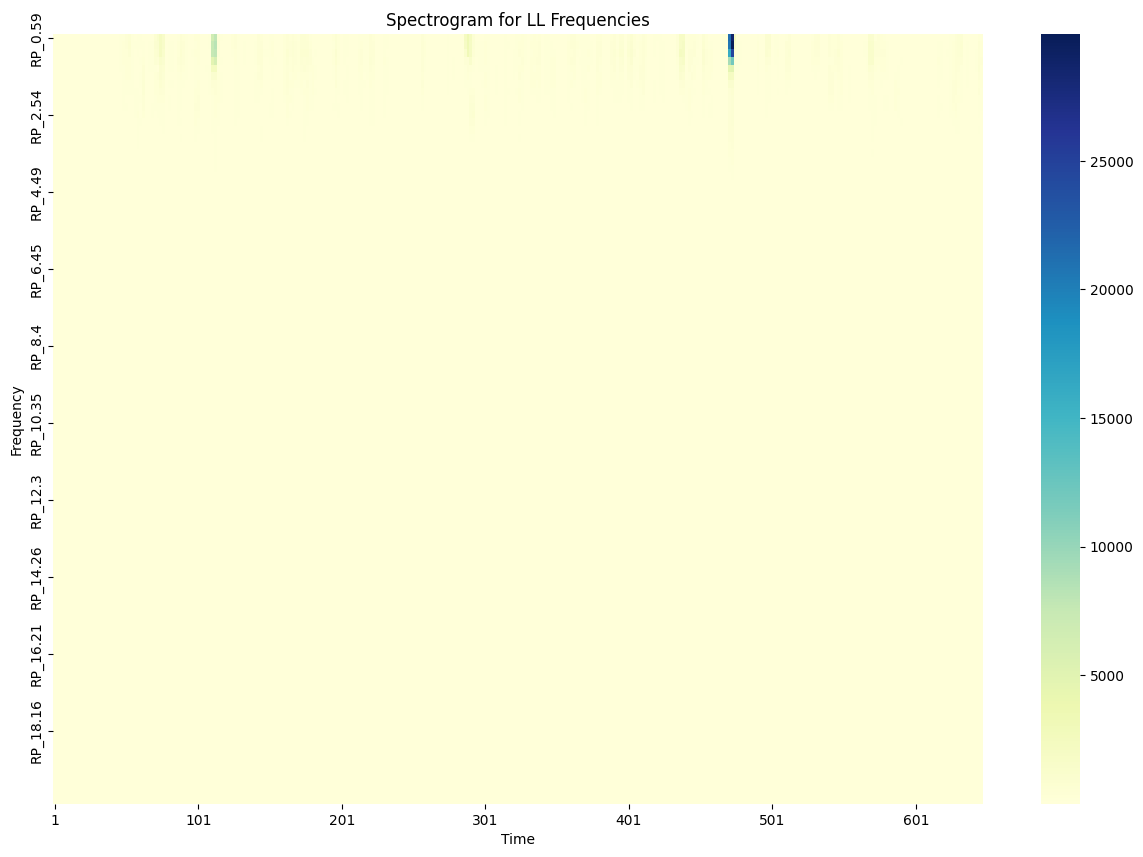

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out columns that start with 'LL' and the time column
ll_columns = [col for col in first_spectrogram_df if col.startswith('RP')]
ll_data = first_spectrogram_df[['time'] + ll_columns]

# Transpose the data for plotting
ll_data_t = ll_data.set_index('time').T

# Plotting the spectrogram for 'LL'
plt.figure(figsize=(15, 10))
sns.heatmap(ll_data_t, cmap="YlGnBu", xticklabels=50, yticklabels=10)
plt.title('Spectrogram for LL Frequencies')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

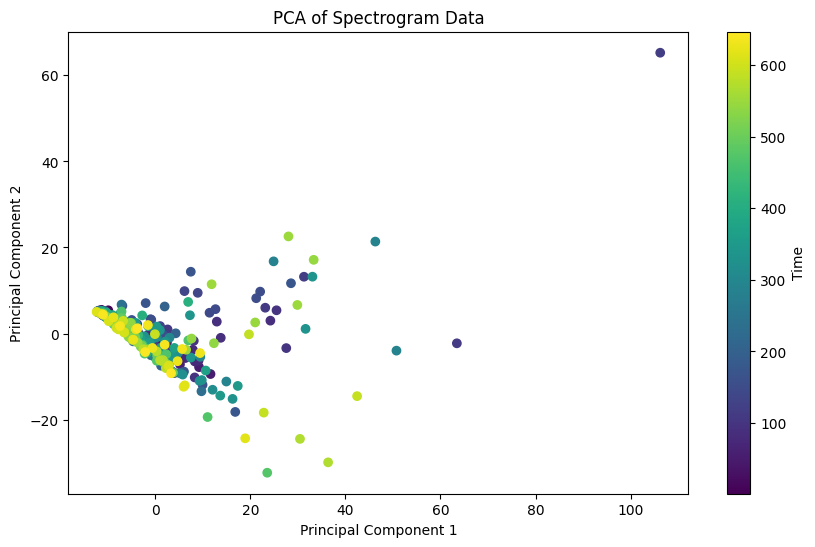

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Filter out all frequency components
frequency_columns = [col for col in first_spectrogram_df.columns if col not in ['Unnamed: 0', 'time']]
frequency_data = first_spectrogram_df[frequency_columns]

# Standardizing the features
scaler = StandardScaler()
frequency_data_scaled = scaler.fit_transform(frequency_data)

# Applying PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(frequency_data_scaled)

# Creating a DataFrame for the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Adding time for plotting
pca_df['time'] = first_spectrogram_df['time']

# Plotting the principal components
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['time'], cmap='viridis')
plt.title('PCA of Spectrogram Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Time')
plt.show()


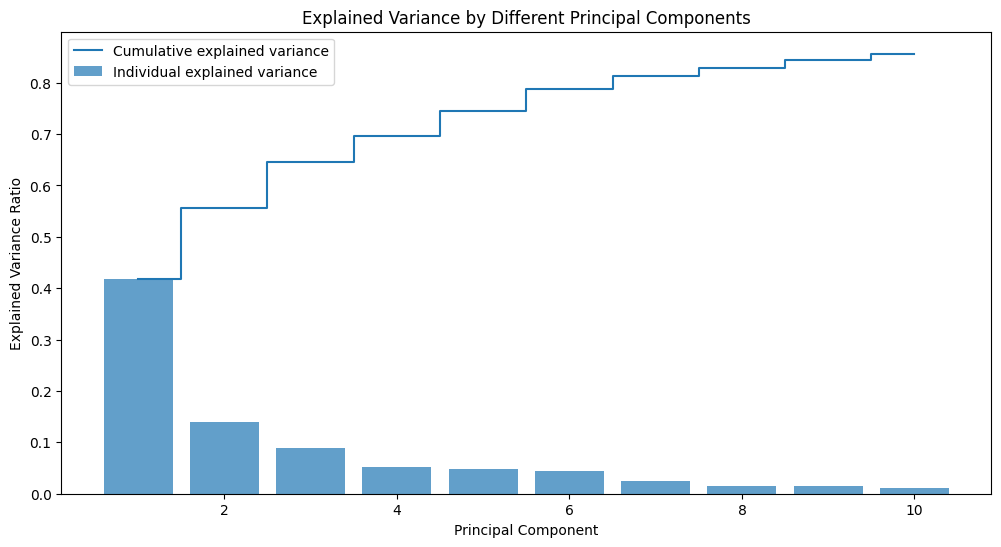

(array([0.41716975, 0.1389117 , 0.08872811, 0.05113862, 0.04878686,
        0.04352899, 0.02526118, 0.01566805, 0.01537925, 0.01192708],
       dtype=float32),
 array([0.41716975, 0.5560814 , 0.64480954, 0.6959482 , 0.74473506,
        0.78826404, 0.8135252 , 0.82919323, 0.8445725 , 0.85649955],
       dtype=float32))

In [29]:
# Applying PCA with more components
pca_extended = PCA(n_components=10)
principal_components_extended = pca_extended.fit_transform(frequency_data_scaled)

# Calculating the variance explained by each component
explained_variance = pca_extended.explained_variance_ratio_

# Calculating cumulative variance
cumulative_variance = explained_variance.cumsum()

# Plotting the variance explained by each component
plt.figure(figsize=(12, 6))
plt.bar(range(1, 11), explained_variance, alpha=0.7, label='Individual explained variance')
plt.step(range(1, 11), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.title('Explained Variance by Different Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.show()

# Output the individual and cumulative variance for detailed analysis
explained_variance, cumulative_variance

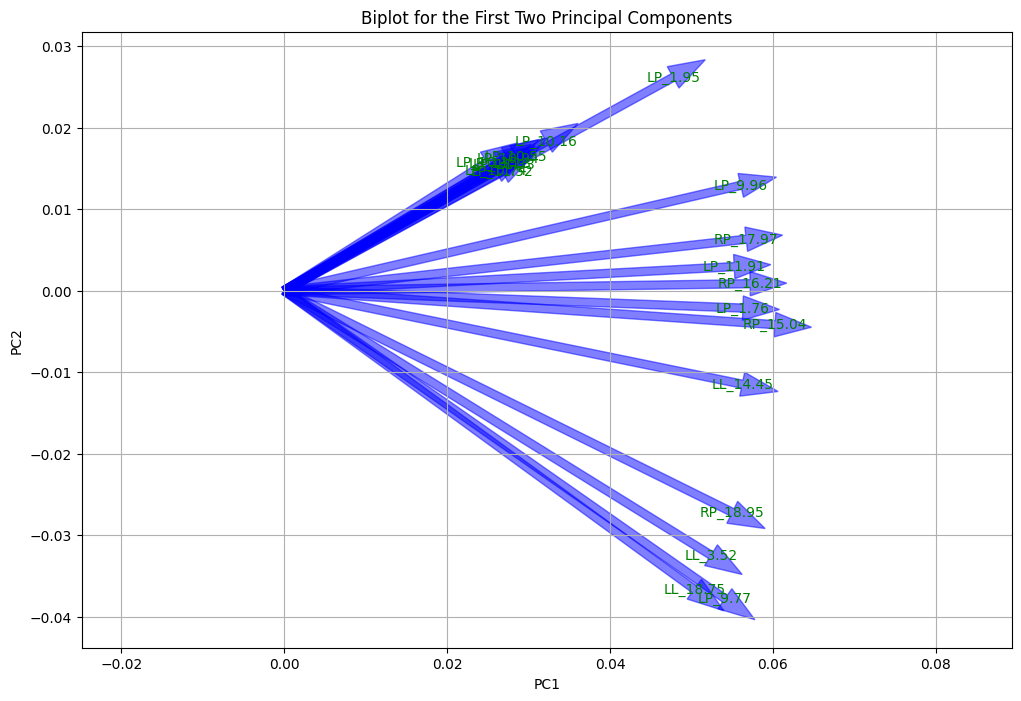

In [30]:
import numpy as np

# Extracting the feature weights for the first two principal components
pc1_weights = pca_extended.components_[0]
pc2_weights = pca_extended.components_[1]

# Creating a DataFrame for better visualization of weights
weights_df = pd.DataFrame({'Feature': frequency_columns, 'PC1 Weight': pc1_weights, 'PC2 Weight': pc2_weights})

# Sorting the DataFrame by the absolute values of PC1 weights for better visibility of dominant features
weights_df_sorted = weights_df.reindex(weights_df['PC1 Weight'].abs().sort_values(ascending=False).index)

# Displaying the top contributing features for PC1
weights_df_sorted.head()

# Creating a simplified biplot
# We will only plot a subset of features for clarity
num_features_to_plot = 20  # Number of features to plot
top_features = weights_df_sorted['Feature'][:num_features_to_plot]

plt.figure(figsize=(12, 8))
for i, feature in enumerate(top_features):
    plt.arrow(0, 0, pc1_weights[i], pc2_weights[i], color='b', alpha=0.5)
    plt.text(pc1_weights[i], pc2_weights[i], feature, color='g', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot for the First Two Principal Components')
plt.grid(True)
plt.axis('equal')
plt.show()


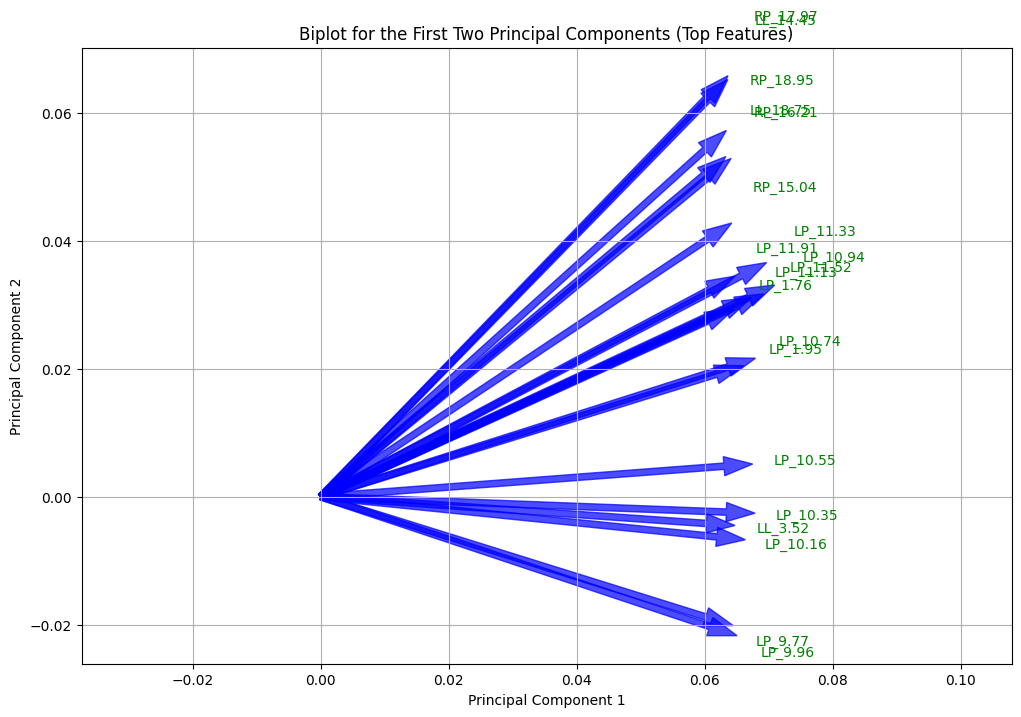

In [31]:
# Selecting a smaller number of top contributing features for the biplot
top_features_count = 20  # Limiting to top 20 features for clarity
top_features_pc1 = weights_df_sorted['Feature'].head(top_features_count).tolist()

# Filtering the weights for these top features
filtered_weights_pc1 = weights_df_sorted[weights_df_sorted['Feature'].isin(top_features_pc1)]

# Creating the biplot for the filtered top features
plt.figure(figsize=(12, 8))
for i in filtered_weights_pc1.index:
    plt.arrow(0, 0, filtered_weights_pc1['PC1 Weight'][i], filtered_weights_pc1['PC2 Weight'][i], 
              color='b', alpha=0.7)
    plt.text(filtered_weights_pc1['PC1 Weight'][i] * 1.2, filtered_weights_pc1['PC2 Weight'][i] * 1.2, 
             filtered_weights_pc1['Feature'][i], color='g', ha='center', va='center')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Biplot for the First Two Principal Components (Top Features)')
plt.grid(True)
plt.axis('equal')
plt.show()


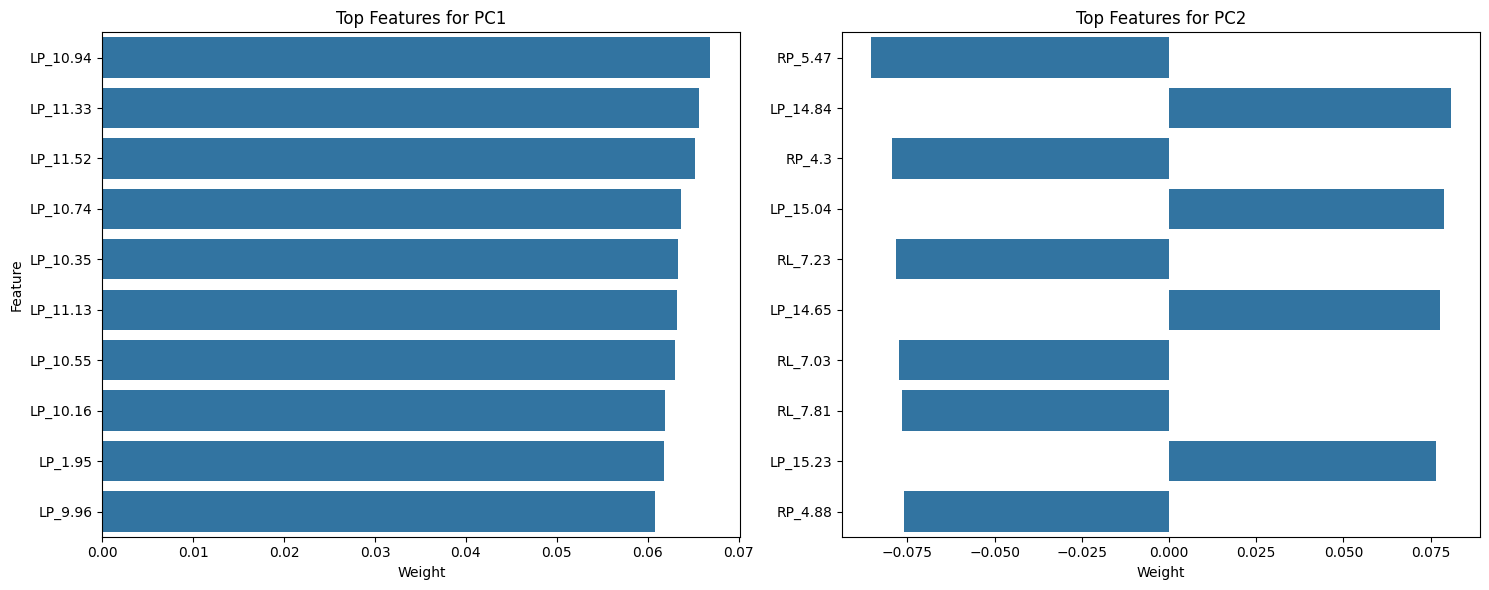

In [32]:
# Plotting the top features for PC1 and PC2
top_features_count = 10  # Number of top features to display

# Sorting the DataFrame by the absolute values of PC1 and PC2 weights
top_features_pc1 = weights_df_sorted.head(top_features_count)
top_features_pc2 = weights_df_sorted.reindex(weights_df_sorted['PC2 Weight'].abs().sort_values(ascending=False).index).head(top_features_count)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# PC1
sns.barplot(x='PC1 Weight', y='Feature', data=top_features_pc1, ax=axes[0])
axes[0].set_title('Top Features for PC1')
axes[0].set_xlabel('Weight')
axes[0].set_ylabel('Feature')

# PC2
sns.barplot(x='PC2 Weight', y='Feature', data=top_features_pc2, ax=axes[1])
axes[1].set_title('Top Features for PC2')
axes[1].set_xlabel('Weight')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [33]:
# Extracting the top features based on their weights in PC1 and PC2
top_features_pc1 = weights_df_sorted[['Feature', 'PC1 Weight']].head(top_features_count)
top_features_pc2 = weights_df_sorted[['Feature', 'PC2 Weight']].head(top_features_count)

# Displaying the top features for PC1 and PC2
top_features_pc1, top_features_pc2

(      Feature  PC1 Weight
 253  LP_10.94    0.066850
 255  LP_11.33    0.065678
 256  LP_11.52    0.065156
 252  LP_10.74    0.063643
 250  LP_10.35    0.063363
 254  LP_11.13    0.063220
 251  LP_10.55    0.063002
 249  LP_10.16    0.061869
 207   LP_1.95    0.061781
 248   LP_9.96    0.060782,
       Feature  PC2 Weight
 253  LP_10.94    0.031167
 255  LP_11.33    0.034490
 256  LP_11.52    0.029820
 252  LP_10.74    0.020275
 250  LP_10.35   -0.002399
 254  LP_11.13    0.029242
 251  LP_10.55    0.004769
 249  LP_10.16   -0.006264
 207   LP_1.95    0.019130
 248   LP_9.96   -0.020284)

In [12]:
first_spectrogram_df.shape

(324, 401)

In [13]:
len(first_spectrogram_df.columns)

401

In [14]:
# Function to extract band features
def extract_band_features(segment):
    # Define EEG frequency bands
    eeg_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 
                'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 45)}
    
    band_features = []
    for band in eeg_bands:
        low, high = eeg_bands[band]
        # Filter signal for the specific band
        band_pass_filter = signal.butter(3, [low, high], btype='bandpass', fs=200, output='sos')
        filtered = signal.sosfilt(band_pass_filter, segment)
        # Extract features like mean, standard deviation, max, min.
        band_features.extend([np.nanmean(filtered), np.nanstd(filtered), np.nanmax(filtered), np.nanmin(filtered)])
    
    return band_features

# Example of using the function on the first segment of EEG data
# Assuming each column in the DataFrame is a different EEG channel and each row is a time point
first_segment = first_spectrogram_df.iloc[0].values
band_features_first_segment = extract_band_features(first_segment)
band_features_first_segment



[-0.06641901811570629,
 2.1995874828193642,
 5.265950021338868,
 -3.833952301607272,
 0.012766943420013135,
 1.883803957220735,
 5.520844476536778,
 -4.335109744169049,
 0.005257020180855469,
 1.5016919857768831,
 4.197522449206028,
 -4.518432369956295,
 2.260550287032408e-05,
 1.7434287849501737,
 9.336887449234329,
 -9.046118152392218,
 1.5523129514578807e-05,
 0.44094765576526684,
 2.4985760276974593,
 -2.7147985085373034]

`extract_features` function provides a set of 20 features (4 features per band * 5 bands) for each PCA component, which collectively capture the essence of the EEG signal's frequency content after dimensionality reduction.

In [15]:
# Assuming you've already performed PCA and have the PCA components in X_pca
# For example:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(first_spectrogram_df)
pca = PCA(n_components = 5)
X_pca = pca.fit_transform(X_scaled)

# Define EEG frequency bands
eeg_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 45)}

# Sample rate (change this to your actual EEG sampling rate)
fs = 200

# Function to filter and extract features
def extract_features(segment):
    features = []
    for band in eeg_bands:
        low, high = eeg_bands[band]
        # Apply bandpass filter
        sos = signal.butter(3, [low, high], btype='bandpass', fs=fs, output='sos')
        filtered = signal.sosfilt(sos, segment)
        # Extract features (mean, standard deviation, etc.)
        features.extend([np.mean(filtered), np.std(filtered), np.max(filtered), np.min(filtered)])
    return features

# Apply feature extraction to each PCA component
features = []
for component in X_pca.T:  # Transpose to iterate over components
    component_features = extract_features(component)
    features.append(component_features)

In [16]:
len(features), len(features[0])

(5, 20)

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(first_spectrogram_df)
pca = PCA(n_components = 1)
X_pca = pca.fit_transform(X_scaled)

# Define EEG frequency bands
eeg_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 12), 'Beta': (12, 30), 'Gamma': (30, 45)}
fs = 200  # Sample rate

# Function to filter and extract features
def extract_features(segment):
    features = []
    for band in eeg_bands:
        low, high = eeg_bands[band]
        sos = signal.butter(3, [low, high], btype='bandpass', fs=fs, output='sos')
        filtered = signal.sosfilt(sos, segment)
        features.extend([np.mean(filtered), np.std(filtered), np.max(filtered), np.min(filtered)])
    return features

# Apply feature extraction to each PCA component
features_list = []
for component in X_pca.T:  # Transpose to iterate over components
    component_features = extract_features(component)
    features_list.append(component_features)

# Define column names for the DataFrame
column_names = []
for band in eeg_bands:
    for stat in ['mean', 'std', 'max', 'min']:
        column_names.append(f"{band}_{stat}")

# Create the DataFrame from the features list
features_df = pd.DataFrame(features_list, columns=column_names)

features_df.head()  

,Delta_mean,Delta_std,Delta_max,Delta_min,Theta_mean,Theta_std,Theta_max,Theta_min,Alpha_mean,Alpha_std,Alpha_max,Alpha_min,Beta_mean,Beta_std,Beta_max,Beta_min,Gamma_mean,Gamma_std,Gamma_max,Gamma_min
0,0.461973,6.405903,14.545973,-9.334645,0.08208,3.190654,7.207133,-7.472792,-0.016404,3.410768,8.884714,-8.820834,-0.014882,7.392369,34.390408,-37.680072,-0.009994,5.374637,21.036649,-20.171375


In [18]:
features_df.shape

(1, 20)

In [19]:
import pandas as pd

# Assuming 'features' is a list of lists with extracted features for each PCA component
# Each sublist in 'features' contains 20 features (4 features per 5 frequency bands)

# Define column names based on the frequency bands and the type of statistic
frequency_bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
statistics = ['mean', 'std', 'max', 'min']
column_names = [f'{band}_{stat}' for band in frequency_bands for stat in statistics]

# Create a DataFrame using the features list and the column names
features_df = pd.DataFrame(features, columns=column_names)

# Now features_df is a DataFrame where each row is a set of features for a PCA component

In [20]:
features_df

,Delta_mean,Delta_std,Delta_max,Delta_min,Theta_mean,Theta_std,Theta_max,Theta_min,Alpha_mean,Alpha_std,Alpha_max,Alpha_min,Beta_mean,Beta_std,Beta_max,Beta_min,Gamma_mean,Gamma_std,Gamma_max,Gamma_min
0,0.461973,6.405903,14.545973,-9.334645,0.082080,3.190654,7.207133,-7.472792,-0.016404,3.410768,8.884714,-8.820834,-0.014882,7.392369,34.390408,-37.680072,-0.009994,5.374637,21.036649,-20.171375
1,-0.122823,2.376226,4.044263,-4.385458,-0.036766,1.768397,5.449025,-5.881670,0.040819,1.739621,4.225008,-4.060529,-0.001532,4.054776,15.958885,-14.407531,0.011335,3.031172,11.474937,-12.113105
2,-0.002997,1.783220,4.295045,-5.391028,0.103730,1.704791,6.013097,-4.721857,-0.015767,1.520912,5.365016,-5.465047,-0.009608,3.460258,19.292197,-22.297973,0.007075,2.530063,15.548736,-15.381502
3,0.250801,1.978281,3.983753,-4.505924,-0.022543,1.834028,4.790483,-6.319339,-0.013679,1.336187,5.053670,-4.790804,0.002896,2.015402,8.984781,-8.210323,-0.001660,1.625683,7.377667,-7.127717
4,-0.122338,1.501979,2.421553,-2.987372,0.027951,1.155982,2.767210,-2.761628,-0.013784,1.241805,3.187199,-3.601038,-0.006126,2.609163,10.893939,-12.103002,-0.002579,1.864532,8.196867,-7.715675


In [21]:
len(features)

5

In [22]:
features

[[0.46197304366375275,
  6.405902502828468,
  14.545973438212759,
  -9.334645287160779,
  0.08208006420594936,
  3.1906544886704857,
  7.207132970983534,
  -7.47279150068395,
  -0.016403676890623504,
  3.4107675987377797,
  8.884714054496298,
  -8.820833902416346,
  -0.014882305890313268,
  7.39236924467688,
  34.39040754778439,
  -37.68007239063732,
  -0.009993636742931099,
  5.3746366187430645,
  21.036648971331413,
  -20.17137536934784],
 [-0.12282307486851787,
  2.3762262835303183,
  4.044263027074404,
  -4.385458076036519,
  -0.03676634890743585,
  1.7683972756225326,
  5.449025386890919,
  -5.881669863683797,
  0.04081877961848087,
  1.7396208142953313,
  4.225008015162782,
  -4.0605285245020255,
  -0.0015322998053312286,
  4.054776295653772,
  15.958884879347798,
  -14.407531077920495,
  0.01133494607610752,
  3.0311720977541676,
  11.474936749425812,
  -12.1131049803795],
 [-0.0029969526113425918,
  1.7832199774006794,
  4.295044751106465,
  -5.391028165356226,
  0.103730427479

In [23]:
first_spectrogram_df.to_csv('first_first_spectrogram_df.csv')

In [24]:
len(features[2])

20

In [25]:
len(band_features_first_segment)

20

* eeg_sub_id - An ID for the specific 50 second long subsample this row's labels apply to.
* test_spectrograms/ Spectrograms assembled using exactly 10 minutes of EEG data.
